# 1. Automated Pipeline

![](https://imgur.com/vKvZapp.png)

# 2. Design Pipeline

## 2.1. Data German Credit

German credit is a dataset of the credit history of 1000 different accounts. Our goal is to use this credit history to predict the likelihood that a customer will repay a loan. The data set includes 20 input variables, including 7 continuous variables (numeric) and 13 categorical variables.

The target variable (the column `Response` in the last position) has the value 1 for Good customers and 2 for Bad customers. Good customer is default customer and we call it Negative Class, while Bad customer is the opposite case and is Positive class.

This is an unbalanced dataset when the Good label (Negative) accounts for 70% and the Bad label only 30% (Positive).

### Overview

In [27]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
import pandas as pd

# Read Data CSV
# Header = None -> Pandas automatically assign the FIRST ROW OF DF (which is the actual column names) to the FIRST ROW (hence your columns no longer have names)
# Header = 0 -> Pandas first deletes column names (header: row 1) and then assign new column names to them (only if you pass names = [........] while loading your file).

df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
                 header=None,names=['StaAcc', 'DuMon', 'CredHis', 'Purpose', 'CredAmt', 'SavAcc', \
                                     'PreEmpl', 'InsRt', 'PerSta', 'OthDebtor', 'PreRe', 'Property', \
                                     'Age', 'IntPla', 'Housing', 'ExstCredit', 'Job', 'NoMain', 'Phone', 'ForWorker', "Response"],
                 index_col = None, sep=" ")
df.head()

,StaAcc,DuMon,CredHis,Purpose,CredAmt,SavAcc,PreEmpl,InsRt,PerSta,OthDebtor,...,Property,Age,IntPla,Housing,ExstCredit,Job,NoMain,Phone,ForWorker,Response
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [29]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StaAcc      1000 non-null   object
 1   DuMon       1000 non-null   int64 
 2   CredHis     1000 non-null   object
 3   Purpose     1000 non-null   object
 4   CredAmt     1000 non-null   int64 
 5   SavAcc      1000 non-null   object
 6   PreEmpl     1000 non-null   object
 7   InsRt       1000 non-null   int64 
 8   PerSta      1000 non-null   object
 9   OthDebtor   1000 non-null   object
 10  PreRe       1000 non-null   int64 
 11  Property    1000 non-null   object
 12  Age         1000 non-null   int64 
 13  IntPla      1000 non-null   object
 14  Housing     1000 non-null   object
 15  ExstCredit  1000 non-null   int64 
 16  Job         1000 non-null   object
 17  NoMain      1000 non-null   int64 
 18  Phone       1000 non-null   object
 19  ForWorker   1000 non-null   object
 20  Response 

In [30]:
# Describe statistics
df.describe()

,DuMon,CredAmt,InsRt,PreRe,Age,ExstCredit,NoMain,Response
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


Preliminary descriptive statistics show that the variables differ by large units. The average low is 1.155, and the highest is up to 3271.258. Therefore, it is likely that we will need to normalize the variables to remove unit differences before building the model.

## 2.2. Distributed Variables

### 2.1.2.1. Continuous Variable

In [32]:
# Select dtype is float/int to find numeric var to plot 
numeric_cols = df.select_dtypes(include=['float','int']).columns
numeric_cols

Index(['DuMon', 'CredAmt', 'InsRt', 'PreRe', 'Age', 'ExstCredit', 'NoMain',
       'Response'],
      dtype='object')

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Destiny Plot (Histogram for continuous var (use bins) with KDE: Kernel Density Estimate)
def _plot_numeric_classes(df, col, bins = 10): #default bins = 10
    sns.distplot(df[col], bins = bins)

# Function distributed numeric for each graph 
def _distribution_numeric(df, numeric_cols, row = 3, col = 3, figsize = (15, 15), bins = 10):
    # numeric_cols: list columns 
    # row: number of rows in grid graph (this case 3x3)
    # col: number of columns in grid graph (this case 3x3)
    # bins: number of bins divided in distribution diagram

    # Print number of graph 
    print('Number of numeric field: ', len(numeric_cols))

    # An assert statement checks whether a condition is true. 
    # True -> keep running. 
    # False -> return AssertionError -> stop executing.
    assert row * (col-1) < len(numeric_cols)

    # Size Figure
    plt.figure(figsize = figsize)

    # Distributed var
    for i in range(1, len(numeric_cols)+1):
      try:
        plt.subplot(row, col, i)                                      # Arrange to order of grid graph
        _plot_numeric_classes(df, numeric_cols[i-1], bins = bins)     # Applied destiny for each num_col 
        plt.title(numeric_cols[i-1])                                  # Title
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break

# Run
_distribution_numeric(df, numeric_cols)

Number of numeric field:  8


### 2.1.2.2. Category Variable

In [33]:
# Choose column with type = object
cate_cols = df.select_dtypes('object').columns

# Function plot 1 bar chart
def _plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()

# Function distribution var for some charts
def _distribution_cate(df, cate_cols, row = 1, col = 2, figsize = (20, 5)):
  print('Number of category field: ', len(cate_cols)) 
  # Size figure
  plt.figure(figsize = figsize)

  # Distributed var
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)
      _plot_bar_classes(df, cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break

_distribution_cate(df, cate_cols, row = 4, col = 4, figsize = (30, 16))

Number of category field:  13


We see many labels in the categorical variable with minimal observations. Empirically, minority labels can be specific to an output label. So we can further investigate how the GOOD/BAD ratio is different in these labels. Their evaluation results can help us draw some valuable conclusions for label classification.

## 2.3. Train, Val & Test Set

In [34]:
from sklearn.model_selection import train_test_split

# Train/Test = 80/20
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify = df['Response'])  # startify: Balanced Good/Bad for train & test set
X_train = df_train.copy()
y_train = X_train.pop("Response")

X_test = df_test.copy()
y_test = X_test.pop("Response") # Pop return value remove > y_test in [1,2]

In [35]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 20) (800,)
(200, 20) (200,)


## 2.4. Preprocessing Model

* **Encoding categorical features** (`OneHotEncoder`).
  
* **Processing missing data** (`SimpleImputer`)
  
* **Removing outlier** (`MinMaxScaler`)

### Separate processing for continuous and categorical variables 

Because continuous variables and categorical variables have different properties, it is possible to train the model on it directly for continuous variables. We will need to encode categorical variables into an arithmetic variable before training. This will require a separate processing pipeline for each type of variable. To build a pipeline in sklearn, we use the `Pipeline()` function. Inside this function is a list of steps to be processed in sequence.

In [36]:
# List names of continuous & category vars
cat_names = list(X_train.select_dtypes('object').columns)
num_names = list(X_train.select_dtypes(['float', 'int']).columns)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Pipeline process for category variable
cat_pl= Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),    # Imputation transformer for completing missing values
           ('onehot', OneHotEncoder())])                            # Encode categorical features as a one-hot numeric array.

# Pipeline process for continuous variable
num_pl = Pipeline(
    steps=[('imputer', KNNImputer(n_neighbors=7)),                 # Imputation for completing missing values using kNN
           ('scaler', MinMaxScaler())])                            # Process noisy data by MinMax scaler,
                                                                   # Transform features by scaling each feature to a given range

The steps of `Pipeline` are a tuple of two elements. The first element is the name of the processing step, and the second element is the corresponding processing method. Naming the processing step helps us to grasp the order and control the entire process.

In [38]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(                                # Applies transformers to columns of an array or pandas DataFrame
    transformers=[('num', num_pl, num_names),                    # Applied pipeline for continuous var
                  ('cat', cat_pl, cat_names)])                   # Applied pipeline for category var

Thus, the continuous variables specified in the list `num_names` will apply the pipeline `num_pl` processing, and the categorical variables in the `cate_names` list will use the `cat_pl` pipeline processing.

## 2.5. Completed Pipeline (Preprocessing Data + Train Model)

After completing the data preprocessing Pipeline, we can get clean output data. Next, we need to pass the cleaned data through the model for training. Both the data preprocessing and model training steps can be further encapsulated in a Pipeline as follows:

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Completed training pipeline
completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor),                  # Pipeline
           ("classifier", RandomForestClassifier())])       # Model

# Training
completed_pl.fit(X_train, y_train)

# Accuracy Train
y_train_pred = completed_pl.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")
# Accuracy Test
y_pred = completed_pl.predict(X_test)
print(f"Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}")

Accuracy on train: 1.00
Accuracy on test: 0.77


Thus, we have completed a simple Pipeline for the solvency classification model. The model has an accuracy of 100% on the train and test sets of 77%, showing overfitting. To overcome overfitting, we can perform `cross-validation`.

# 3. Cross validation

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

## 3.1. Model Measure

### 3.1.1. Predict Problem

$$\text{MSE (Mean Squared Error)} = \frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2$$

$$\text{RMSE (Root Mean Squared Error)} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2)}$$

$$\text{MAE (Mean Absolute Error)} = \frac{1}{n}\sum_{i=1}^{n} |y_i-\hat{y}_i|$$

$$\text{MAPE (Mean Absolute Percentage Error)} = \frac{1}{n}\sum_{i=1}^{n} |\frac{y_i-\hat{y}_i}{y_i}|$$

### 3.1.2. Classification Problem

For example, a binary classification problem with a cross-tabulation of the results between the actual and the forecast as follows:

![](https://phamdinhkhanh.github.io/assets/images/20200813_ModelMetric/pic1.png)

Các chỉ số TP, FP, TN, FN lần lượt có ý nghĩa là :

* TP (True Positive): Tổng số trường hợp dự báo khớp Positive.
* TN (True Negative): Tổng số trường hợp dự báo khớp Negative.
* FP (False Positive): Tổng số trường hợp dự báo các quan sát thuộc nhãn Negative thành Positive. Những sai lầm của False Positive tương ứng với sai lầm loại I (_type I error_), chấp nhận một điều sai. Thực tế cho thấy sai lầm loại I thường gây hậu quả nghiêm trọng hơn so với sai lầm loại II được tìm hiểu bên dưới.
* FN (False Negative): Tổng số trường hợp dự báo các quan sát thuộc nhãn Positive thành Negative. Trong trường hợp này chúng ta mắc sai lầm loại II (_type II error_), bác bỏ một điều đúng.

Đối với bài toán phân loại thì ta quan tâm tới độ chính xác dự báo trên toàn bộ bộ dữ liệu là bao nhiêu? Do đó thước đo phổ biến nhất là `accuracy`. 

$$\text{Accuracy} = \frac{TP+TN}{\text{total sample}} = \frac{55+850}{1000} = 90.5 \%$$

**Bài tập: Vì sao trong trường hợp mất cân bằng dữ liệu thì accuracy không còn là thước đo mô hình tốt?**

Trong tính huống mô hình bị mất cân bằng thì accuracy không còn là thước đo tốt nên được thay thế bằng `precision, recall`. 

$$\text{Precision} = \frac{TP}{\text{total predicted positive}} = \frac{TP}{TP+FP} = \frac{55}{55+50} = 52.4 \%$$

$$\text{Recall} = \frac{TP}{\text{total actual positive}} = \frac{TP}{TP+FN} = \frac{55}{55+45}=55 \%$$

Hai chỉ số này lần lượt giúp đánh giá tỷ lệ dự báo chính xác positive trên tổng số trường hợp được dự báo là positive và tỷ lệ dự báo chính xác positive trên thực tế. Thực sự rất khó để nói lựa chọn `precision` hay `recall` là tốt hơn nên chúng ta dùng `f1-score` là trung bình điều hoà đại diện cho cả precision và recall. Ngoài ra còn một số chỉ số nâng cao hơn cũng được lựa chọn để đánh giá sức mạnh phân loại như `AUC, Gini Index, Cohen's Kappa` tuy nhiên `f1-score` và `accuracy` theo mình nghĩ vẫn là hai chỉ số cơ bản nhất cho bài toán phân loại mà bạn cần nắm vững.

$$f_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

$f_{\beta}$ là trường hợp tổng quát hơn của $f_1$ khi ta coi mức độ quan trọng của `recall` bằng $\beta$ lần `precision`.

![](2021-12-28-15-50-20.png)

Bộ dữ liệu [german credit](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) có tính chất mất cân bằng nên chúng ta sẽ lựa chọn `f-score` thay cho `accuracy`. Hơn nữa trong mô tả của bộ dữ liệu đã qui định:

`It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).`

Tức là một trường hợp `False Negative` có mức độ sai lầm bằng 5 trường hợp `False Positive` nên ta sẽ lựa chọn $\beta^2=5$.

In [41]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

# Tính fbeta score
def fbeta(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=np.sqrt(5))

## 3.2. Cross-Validation

To perform cross-validation, we use class `RepeatedStratifiedKFold()` where `n_splits` is the number of splits and `n_repeates` is the number of iterations the cross-validation process. Thus we will have a total of `n_splits x n_repeats` data reviews.

The function `cross_val_score()` will calculate the model measure on the training passes.

In [42]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Identifying KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Identifying metric for model
metric = make_scorer(fbeta)

# Accuracy
scores = cross_val_score(completed_pl, X_train, y_train, scoring = metric, cv = cv, n_jobs = -1)
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

Mean Fbeta: 0.890 0.024


## 3.3. Accuracy some models 

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# List model chose
models = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]

# Identifying KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []

# Accracy
for model in models:
  completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ('classifier', model)])

  scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
  all_scores.append(scores)

### Visualize BoxPlot

Next, we will plot the score distribution between the models, using a Box Plot chart to help identify outliers and find out the distribution pattern of the data. Specifically, this chart identifies the cutoff thresholds at the 25% percentile (which is the value for which 25% of the observations are less than this value), the median (or the 50% percentile), the 75% percentile, and the 75% percentile. denoted by $Q_1,Q_2,Q_3$ respectively. 

Based on $IQR$, outliers will be determined if outside the highest and lowest values. 

![](2021-12-28-16-29-09.png)

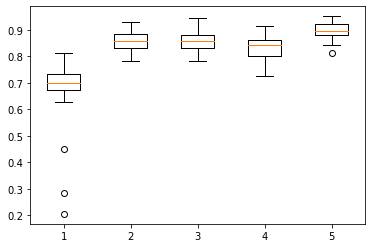

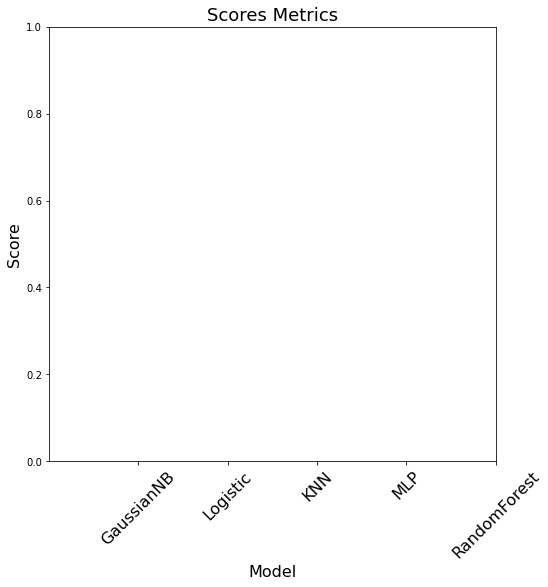

In [99]:
import matplotlib.pyplot as plt

# Draw boxplot 
model_names = ['GaussianNB', 'Logistic', 'KNN', 'MLP', 'RandomForest']
plt.boxplot(all_scores)

# Label
plt.figure(figsize=(8, 8))
plt.xlabel('Model', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.title("Scores Metrics", fontsize=18)
plt.show();

Looking at the chart, we can see that `RandomForest` is the algorithm with the highest accuracy when the score fluctuates between 0.83 and 0.95 and the average is about 0.9, so we will choose this model class to develop production.

# 4. GridSearch

GridSearch là một kỹ thuật giúp tìm kiếm tham số phù hợp cho mô hình đối với một bộ dữ liệu cụ thể. Trong sklearn chúng ta có thể sử dụng `GridSearchCV` để tạo không gian tham số. Để dễ hình dung hơn về GridSearch chúng ta hãy cùng áp dụng chúng trên bộ dữ liệu `German Credit`.

Đầu tiên chúng ta sẽ tạo ra một Class `ClassifierfSwitcher` mà thuộc tính `estimator` của nó là một mô hình trong sklearn. Đây là một tham số có thể search được trên gridsearch.

In [87]:
from sklearn.base import BaseEstimator
class ClassifierSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = RandomForestClassifier(),
  ):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 
      
      self.estimator = estimator

  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self

  def predict(self, X, y=None):
      return self.estimator.predict(X)

  def predict_proba(self, X):
      return self.estimator.predict_proba(X)

  def score(self, X, y):
      return self.estimator.score(X, y)

Tiếp theo chúng ta sẽ kết hợp giữa hai bước tiền xử lý và huấn luyện để tạo thành một pipeline hoàn chỉnh và thực hiện gridsearch trên pipeline này.

In [88]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[("pre", preprocessor), ("clf", ClassifierSwitcher())]
)

Pipeline sẽ gồm hai bước là `pre` và `clf`. Chúng ta chỉ cần quan tâm tới việc tìm kiếm trên `clf` thông qua các parameters của class `ClassifierSwitcher` như sau:

In [89]:
parameters = [
    {
        'clf__estimator': [LogisticRegression()], # SVM if hinge loss / logreg if log loss
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4]
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth': [5, 10],
        'clf__estimator__criterion': ('gini', 'entropy')
    },
]

Giải thích một chút: Bạn không hiểu `clf__estimator__penalty` nghĩa là gì phải không? Bởi vì parameters sẽ được thông dịch trước khi đưa vào gridsearch nên dấu `__` ở trên chính là dấu `.` sau khi thông dịch. Như vậy `clf__estimator__penalty` chính là `clf.estimator.penalty`.

Tiếp theo ta sẽ thực hiện grid search trên tập train. Quá trình grid search sẽ thực hiện cross validation với k=5 và kết quả để quyết định mô hình tốt nhất là trung bình trên 5 lượt đánh giá theo hàm fbeta.

In [90]:
metric = make_scorer(fbeta)
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, scoring=metric, return_train_score=True, error_score=0, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=7)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['DuMon',
                                                                          'CredAmt',
                                                                          'InsRt',
                                                                          'PreRe',
                                                                          'Ag

Để tìm ra mô hình tốt nhất từ `grid search` ta sử dụng `gscv.best_estimator_`.

In [91]:
gscv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['DuMon', 'CredAmt', 'InsRt',
                                                   'PreRe', 'Age', 'ExstCredit',
                                                   'NoMain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                      

Các tham số tốt nhất.

In [92]:
gscv.best_params_

{'clf__estimator': RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50),
 'clf__estimator__criterion': 'entropy',
 'clf__estimator__max_depth': 5,
 'clf__estimator__n_estimators': 50}

Điểm số cao nhất.

In [94]:
gscv.best_score_

0.9235913518935795

# 6. Exercise

Từ một trong các bộ dữ liệu:

* [Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) về chuẩn đoán ung thư vú. 
* [Siabetes](https://archive.ics.uci.edu/ml/datasets/diabetes) chuẩn đoán bệnh tiểu đường.
* [HMEQ](https://www.kaggle.com/ajay1735/hmeq-data) phân loại hồ sơ cho vay mua nhà.
* [Bonston Housing](https://github.com/phamdinhkhanh/datasets/blob/master/BostonHousing.csv) dự báo giá nhà ở Bonston. 
* [Churn Customer](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) dự đoán khách hàng rời bỏ.

Bạn hãy thực hiện các bài tập sau: 

1. Thống kê mô tả và vẽ biểu đồ phân phối trên các trường của tập dữ liệu này. Đánh giá sơ bộ về tính chất phân phối của các biến.

2. Hãy tạo thành một pipeline hoàn chỉnh để xử lý dữ liệu từ thô sang tinh.

3. Phân chia tập train/test và lựa chọn metric cho bài toán.

4. Lựa chọn một lớp mô hình phù hợp, thực hiện cross validation để huấn luyện và đánh giá mô hình đó trên tập train.

5. Triển khai lại quá trình ở bài 4 trên nhiều lớp mô hình khác nhau.

6. Vẽ biểu đồ thể hiện kết quả của các mô hình và Kết luận đâu là mô hình tốt nhất. 

7. Dựa vào lớp mô hình tốt nhất được lựa chọn, thực hiện grid search trên không gian tham số của nó.